# **DEEP LEARNING FINAL PROJECT**


### RON KEINAN 203735857






____________________________________________________________________________________________________________________________________________________________________________________

## Introduction:

As part of the graduation project of the Deep Learning course,
We will carry out a research project in the field of health communities.
A database containing various Hebrew texts of health forums will be selected, and we will try to classify the medical community to which the texts belong.

**The classification will by by users and by texts - for 1 from 41 health communities!**

The classification  will be done using different models and we will compare the results:

1.   Random forest based on eigen vectors of the laplacian.
2.   Node2Vec based on random walks inside a LR model.
3.   GCN based on adjacency and feature matrix multiply - inside a LR model.
4.   RNN with pretraind embeddings by word2 vec.

____________________________________________________________________________________________________________________________________________________________________________________

## Part 01 - Get data and build representaions

##### **The Camoni health communites website**

Camoni is a unique non-profit social network and the first of its kind in Israel, aimed to empower patients with chronic diseases and their family members.

Camoni is part of a growing global network of digital tools availing users with professional knowledge and advice together with social network access in order to facilitate problem solving, emotional support and sharing. The platform provides a variety of social and professional tools for coping with chronic health conditions, among them reliable, professional content, conversation walls, groups for counseling and sharing, blogs, medical news and updates, and healthcare professionals who voluntarily contribute time to lead the various communities and provide counselling to patients with chronic diseases and their families.

Among the many communities using the Camoni platform today are patients with Type-1 and Type-2 diabetes, heart diseases, pain, obesity, stroke, hypertension, attention deficit disorders, kidney disease, eating disorders, multiple sclerosis, spinal disorders, respiratory disorders, Crohn’s disease and colitis, depression and anxiety disorders, osteoporosis, war and terrorist attack-related post-traumatic disorders, hyperactive bladder disorders, psoriasis, joint disorders, breast cancer, Sjogren’s syndrome, ovarian cancer, colon cancer and multiple myeloma.

The website was established in 2009 by Prof. Mordechai Sani and the Gertner Institute - a national research institute for the study of epidemiology & health policy research in Israel. 

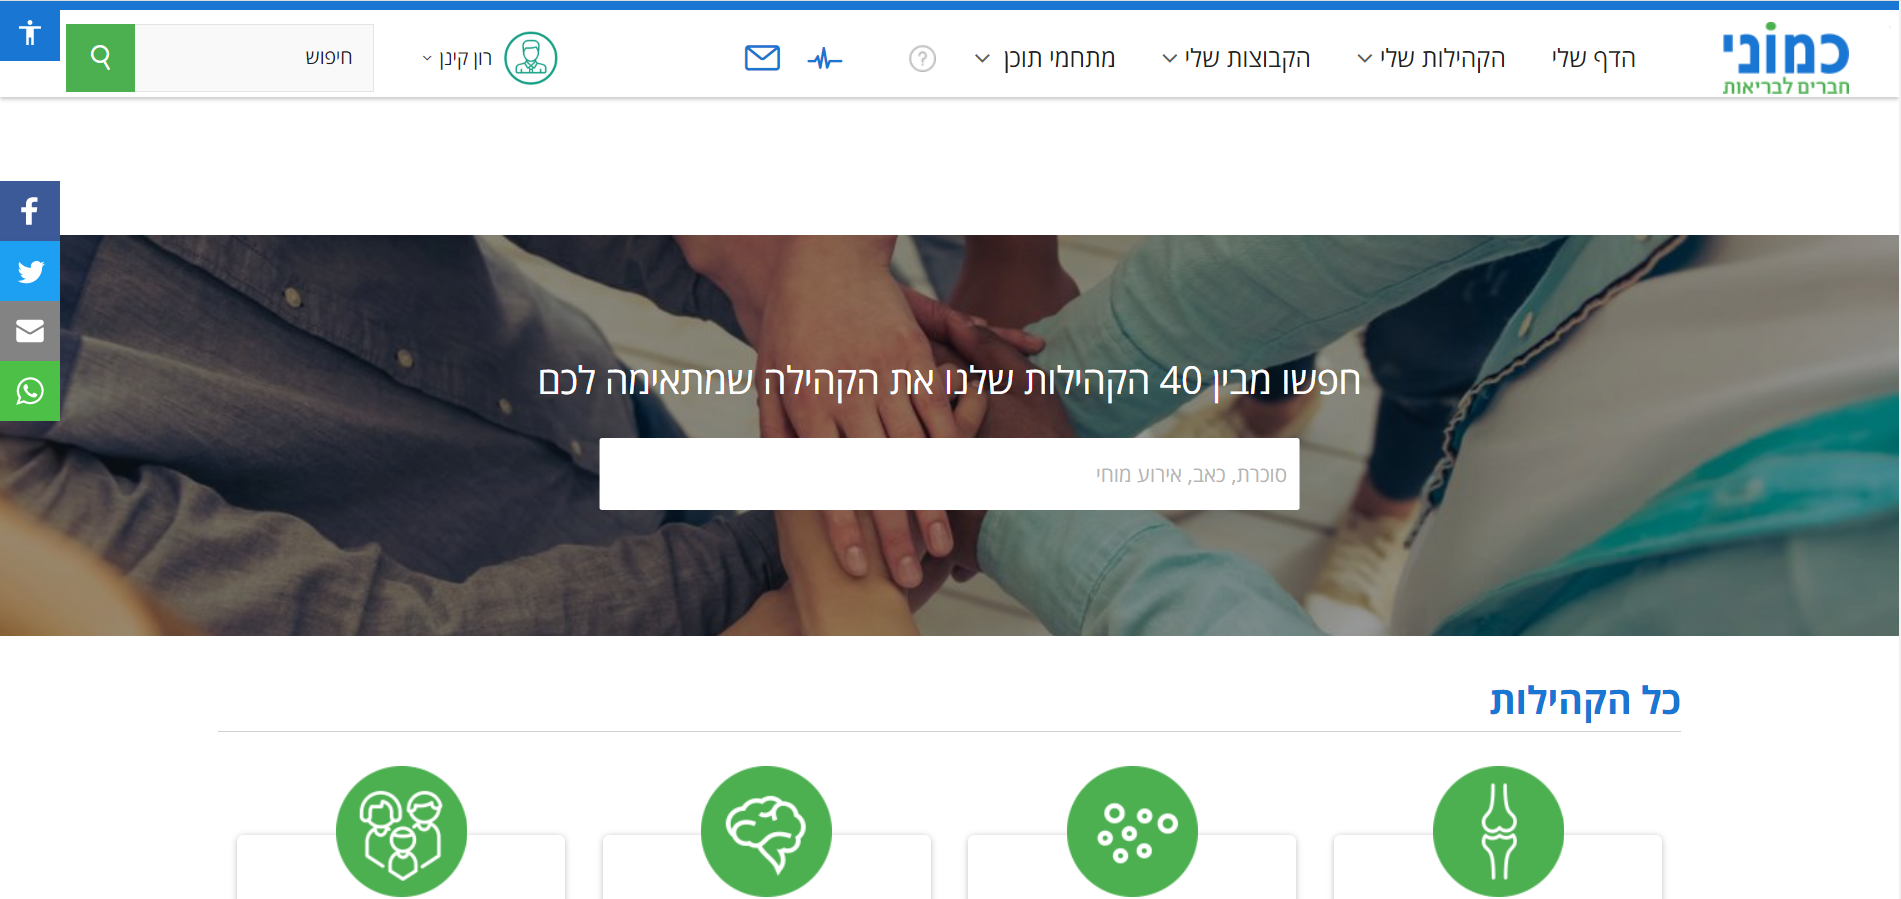

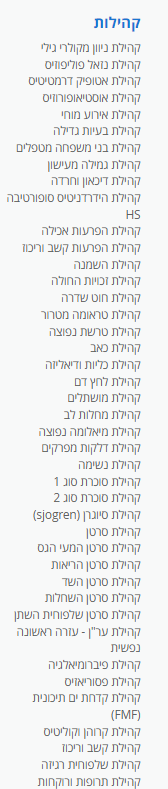

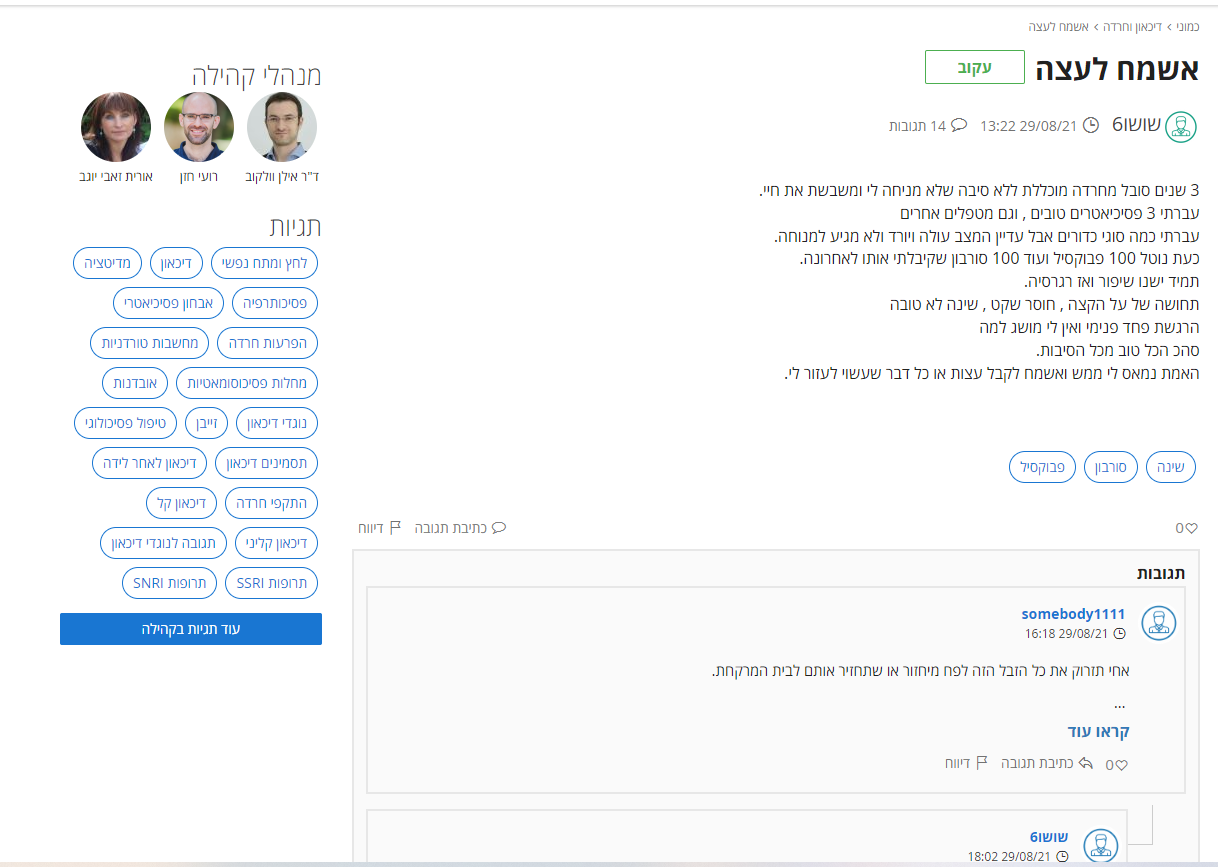

##### **Building the data set**

Posts download:

In [ ]:
# -*- coding: cp1255 -*-   # sets the coding to hebrew and not gibrish
import requests
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

CHROME_DRIVER_PATH = "C:\\Users\\ronke\\Desktop\\פרויקט גמר\\chromedriver.exe"
DEFAULT_URL = "https://www.camoni.co.il/411804/"
DOWNLOAD_PATH  ="C:\\Users\\ronke\\Desktop\\פרויקט גמר\\parsing\\new_posts\\"
LOG_FILE_PATH = DOWNLOAD_PATH + "\log_file_posts_download_" + str(datetime.now().strftime("%d-%m-%y")) + ".txt"
posts_count = 0


def double_print(my_str):
    global log_file
    print(my_str)
    log_file.write(my_str + "\n")


log_file = open(LOG_FILE_PATH, 'a')
double_print("\n" + str(datetime.now().strftime("%d/%m/%y %H:%M:%S")) + " - Starting getting users file")
double_print(
    "-----------------------------------------------------------------------------------------------------------------")

chrome_options = Options()
chrome_options.add_argument("--headless")
browser = webdriver.Chrome(ChromeDriverManager().install(), options=chrome_options)

"""
525000-571066 V
10000-50000 V - check if real posts
100000-140000 V
500000-525000”
"""
FROM = 18790
TO = 580000
for page_number in range(FROM, TO):  # range(FROM, TO):
    url = DEFAULT_URL + str(page_number)

    try:
        browser.get(url)
        response = browser.page_source
    except Exception as e:
        double_print(str(page_number) + " failed because: " + str(e))
        continue

    if "p404" not in response:
        try:
            with open(DOWNLOAD_PATH + str(page_number) + ".html", "wb") as file:  # save as
                file.write(response.encode())
        except Exception as e:
            double_print(str(page_number) + " failed because: " + str(e))
            continue

        double_print(
            str(datetime.now().strftime("%d/%m/%y - %H:%M:%S")) + " - created successfully file: " + str(page_number))
        posts_count += 1
    else:
        double_print(str(datetime.now().strftime("%d/%m/%y - %H:%M:%S")) + " - failed file # " + str(
            page_number) + " status code: 404")

    # time.sleep(0.5)
    if ((page_number-FROM) % 100) == 0:
        log_file.flush()

double_print(
    "-----------------------------------------------------------------------------------------------------------------")
double_print(
    "\n" + str(datetime.now().strftime("%d/%m/%y - %H:%M:%S")) + " - Downloaded " + str(posts_count) + " files!")
log_file.close()


In [ ]:
posts parsing:

In [ ]:
# -*- coding: cp1255 -*-   # sets the coding to hebrew and not gibrish
import datetime
import os
import random
import time
from time import strftime, localtime
from bs4 import BeautifulSoup
import xlsxwriter

DEFAULT_URL = "https://www.camoni.co.il/411804/"
OUTPUT_FOLDER = u'C:\\Users\\ronke\\Desktop\\פרויקט גמר\\parsing\\'
#INPUT_DIR = "C:\\Users\\ronke\\Desktop\\פרויקט גמר\\parsing\\TRY"
INPUT_DIR = "C:\\Users\\ronke\\Desktop\\פרויקט גמר\\parsing\\new_posts_with_selenium"

FAILURE = -1
COMMUNITIES = ['אוסטאופורוזיס', 'אטופיק דרמטיטיס', 'אירוע מוחי', 'בני משפחה מטפלים', 'בעיות גדילה', 'גמילה מעישון',
               'דיכאון וחרדה', 'הידרדניטיס סופורטיבה HS', 'הפרעות אכילה', 'השמנה', 'זכויות החולה', 'חוט שדרה',
               'טראומה מטרור ומלחמה', 'טרשת נפוצה', 'כאב', 'כליות ודיאליזה', 'לחץ דם', 'מושתלים', 'מחלות לב',
               'מיאלומה נפוצה', 'מפרקים', 'ניוון מקולרי גילי (AMD)', 'נשימה', 'סוכרת סוג-1', 'סוכרת סוג-2',
               'סיוגרן (sjogren)', 'סרטן', 'סרטן המעי הגס', 'סרטן הריאות', 'סרטן השד', 'סרטן השחלות',
               'סרטן שלפוחית השתן', 'ער"ן - עזרה ראשונה נפשית', 'פיברומיאלגיה', 'פסוריאזיס', 'קדחת ים תיכונית (FMF)',
               'קרוהן וקוליטיס', 'קשב וריכוז', 'שלפוחית רגיזה', 'תרופות ורוקחו']


class Talkback:
    def __init__(self):
        self.Content = ""
        self.Publisher = ""
        self.Date = ""
        self.Time = ""
        self.Word_number_in_post = 0
        self.Char_number_in_post = 0
        self.Likes_num = 0


class Full_Post:
    def __init__(self):
        self.Number = ""
        self.ID = ""
        self.Date = ""
        self.Time = ""
        self.Group = ""
        self.Group_type = ""
        self.Author = ""
        self.Title = ""
        self.Content = ""
        self.Word_number_in_post = 0
        self.Char_number_in_post = 0
        self.Talkback_list = []
        self.Talkbacks_num = 0
        self.URL = ""
        self.Likes_num = 0


def get_full_post_details(file_to_parse, post_number):
    post = Full_Post()
    post.ID = (file_to_parse[-11:-5]).replace('\\', '')  # take end of path as file name

    fp = open(file_to_parse, "rb")
    page = fp.read()
    soup = BeautifulSoup(page, 'html.parser')

    for elem in soup.find_all(["a", "p", "div", "h3", "br"]):  # create new line in text objects
        elem.append('\n')

    # ______________________________________________________________________________________________________________________________________________________________
    EmptyPage = soup.find('div', attrs={'class': "error-num"})
    if EmptyPage is not None:
        print(file_to_parse, "not Found", EmptyPage.text)
        post.Number = post_number - 1
        return FAILURE

    stuff = soup.find('a', attrs={'class': "communityLink"})
    if stuff is None:  # not community
        return FAILURE
    post.Group = stuff.text.rstrip('\n')
    if post.Group=='':
        post.Group="קבוצה שנסגרה"

    if post.Group in COMMUNITIES:
        post.Group_type = "community"
    else:
        post.Group_type = "group"

    content = soup.find('div', attrs={'class': "wrappContent"})
    stuff = content.find('div', attrs={'class': "postTitle"})
    if stuff is None:
        post.Title = ""
    else:
        post.Title = stuff.text
    stuff = content.find('div', attrs={'class': "MessageSubject"})
    if stuff is None:
        stuff = content.find('div', attrs={'class': "Bg_text"})
        if stuff is None:
            post.Content = "ERROR"
        else:
            post.Content = stuff.text
    else:
        post.Content = stuff.text

    # stuff = content.find('a', attrs={'class': "postMemberName"})
    stuff = content.find('div', attrs={'class': "postDetail"})

    if stuff is None:
        stuff = content.find('img', attrs={'alt': "Anonymouse"})
    if stuff is None:
        post.Author = "ERROR"
    else:
        post.Author = stuff.text

    stuff = content.find('div', attrs={'class': "postDetail"})
    if stuff is None:
        post.Author = "ERROR"
    else:
        post.Author = stuff.text

    try:
        stuff = content.findAll('div', attrs={'class': "postDetail"})
        post_time = stuff[1].text
        times = get_correct_time(post_time, file_to_parse)

        post.Date = str(times[0])
        post.Time = str(times[1])

    except Exception as e:
        post.Time = "ERROR"
        post.Date = "ERROR"
        print("error with date or time because: ", str(e))

    post.Word_number_in_post = len(post.Content.split())
    post.Char_number_in_post = len(post.Content)

    talckbacks_num = stuff[2].text.split()
    post.Talkbacks_num = talckbacks_num[0]

    stuff = soup.findAll('div', attrs={'class': "iComm"})
    for comment in stuff:
        current_talkback = Talkback()
        try:
            comment_data = comment.find('div', attrs={'class': "readMoreFullText"})
            if comment_data is None:
                comment_data = comment.find('div', attrs={'class': "textCom enableEmoticons"})
            if comment_data is None:
                comment_data = comment.find('div', attrs={'class': "textCom enableEmoticons1"})

            if comment_data is not None:
                current_talkback.Content = comment_data.text
        except Exception as e:
            current_talkback.Content = "ERROR" + str(e)

        try:
            comment_writer = comment.find('a', attrs={'class': "postMemberName"})
            if comment_writer is None:
                comment_writer = comment.find('div', attrs={'class': "nameComm"})

            current_talkback.Publisher = comment_writer.text
        except Exception as e:
            current_talkback.Publisher = "ERROR" + str(e)

        try:
            comment_time = comment.find('div', attrs={'class': "commentTime"}).text
            comment_times = get_correct_time(comment_time, file_to_parse)
            current_talkback.Date = str(comment_times[0])
            current_talkback.Time = str(comment_times[1])
        except Exception as e:
            current_talkback.Date = "ERROR" + str(e)
            current_talkback.Time = "ERROR" + str(e)

        try:
            comment_likes = comment.find('span', attrs={'class': "likeTitle"}).text
            if len(comment_likes) == 0:
                current_talkback.Likes_num = 0
            else:
                current_talkback.Likes_num = int(comment_likes)
        except Exception as e:
            current_talkback.Likes_num = -1
            print(str(e))

        current_talkback.Word_number_in_post = len(current_talkback.Content.split())
        current_talkback.Char_number_in_post = len(current_talkback.Content)

        post.Talkback_list.append(current_talkback)
    # -------

    post.URL = DEFAULT_URL + post.ID

    try:
        post_likes = soup.find('span', attrs={'class': "likeTitle"}).text
        if len(post_likes) == 0:
            post.Likes_num = 0
        else:
            post.Likes_num = int(post_likes)
    except Exception as e:
        post.Likes_num = -1
        print(str(e))

    return post


def get_correct_time(time, file):
    if "אתמול" in time:
        modification_time_epoch = os.path.getmtime(file)
        modification_time_day = datetime.datetime.fromtimestamp(modification_time_epoch).strftime('%d/%m/%Y')
        times = (time.replace("אתמול ב:", modification_time_day)).split()
        times[0] = times[0][:-4] + times[0][-2:]  # make year only 2 digits
    elif "לפני" in time:
        time_list = time.split()
        subtract = int(time_list[1])
        modification_time_epoch = os.path.getmtime(file)
        modification_time_day = datetime.datetime.fromtimestamp(modification_time_epoch)
        good_date = (modification_time_day - datetime.timedelta(days=subtract)).strftime('%d/%m/%Y')
        good_date = good_date[:-4] + good_date[-2:]  # make year only 2 digits
        rand_hour = datetime.time(random.randrange(23), random.randrange(59)).strftime('%H:%M')
        times = [good_date, rand_hour]
    elif "בשעה האחרונה" in time:
        modification_time_epoch = os.path.getmtime(file)
        modification_time_day = datetime.datetime.fromtimestamp(modification_time_epoch).strftime('%d/%m/%Y %H:%M')
        times = modification_time_day.split()
        times[0] = times[0][:-4] + times[0][-2:]  # make year only 2 digits
    else:
        times = time.split()
    return times


def create_file(file_type):
    CAMONI_FILE_NAME = OUTPUT_FOLDER + "Camoni_" + str(file_type) + "__" + strftime("%d-%b-%Y-%H;%M",
                                                                                    localtime()) + ".xlsx"
    book = xlsxwriter.Workbook(CAMONI_FILE_NAME, {'strings_to_urls': False})  # prevent exception of "since it exceeds Excel's limit of 65,530 URLS per worksheet"
    sheet_full = book.add_worksheet(file_type+'_FULL')  # cell_overwrite_ok=True.
    sheet_communities = book.add_worksheet(file_type+'_COMMUNITIES')  # cell_overwrite_ok=True.
    sheet_groups = book.add_worksheet(file_type+'_GROUPS')  # cell_overwrite_ok=True.

    style = book.add_format({'bold': True, 'font_color': 'black'})
    print("created file: ", CAMONI_FILE_NAME)
    return book, sheet_full, sheet_communities, sheet_groups, style


def create_soup_posts_list():
    parsed_post_number = 0

    directory = os.fsencode(INPUT_DIR)
    posts_list = []

    for path, subdirs, files in os.walk(directory):
        for name in sorted(files):
            file = os.path.join(path, name)
            try:
                post = get_full_post_details(file.decode(), parsed_post_number)
            except Exception as e:
                print("error parsing with: " + str(name) + "because: " + str(e))
                continue
            if post == FAILURE:
                print("error parsing with: " + str(name))
                continue

            posts_list.append(post)
            parsed_post_number += 1

            if parsed_post_number % 500 == 0:  # save  file every 100 iterations
                print("-----------------------------------------------------------------parsed files: " + str(
                    parsed_post_number) + "---------------------------------------------------------------------")

    return posts_list


def create_headlines_posts_file(posts_sheet, style):
    posts_sheet.write(0, 0, u'Page Number', style)
    posts_sheet.write(0, 1, u'URL', style)
    posts_sheet.write(0, 2, u'Date', style)
    posts_sheet.write(0, 3, u'Time', style)
    posts_sheet.write(0, 4, u'Community', style)
    posts_sheet.write(0, 5, u'Group/Community', style)
    posts_sheet.write(0, 6, u'Post publisher', style)
    posts_sheet.write(0, 7, u'Title', style)
    posts_sheet.write(0, 8, u'Post content', style)
    posts_sheet.write(0, 9, u'Post words number', style)
    posts_sheet.write(0, 10, u'Post chars number', style)
    posts_sheet.write(0, 11, u'Post likes', style)
    posts_sheet.write(0, 12, u'Comment number', style)
    comment_idx = 1
    c1 = u'comment user #'
    c2 = u'comment #'
    for column in range(13, 20, 2):
        posts_sheet.write(0, column, c1 + str(comment_idx), style)
        posts_sheet.write(0, column + 1, c2 + str(comment_idx), style)
        comment_idx += 1


def create_headlines_comments_file(comments_sheet, style):
    comments_sheet.write(0, 0, u'Page Number', style)
    comments_sheet.write(0, 1, u'URL', style)
    comments_sheet.write(0, 2, u'Date', style)
    comments_sheet.write(0, 3, u'Time', style)
    comments_sheet.write(0, 4, u'Community', style)
    comments_sheet.write(0, 5, u'Group/Community', style)
    comments_sheet.write(0, 6, u'Comment author', style)
    comments_sheet.write(0, 7, u'Comment', style)
    comments_sheet.write(0, 8, u'Post/Comment', style)
    comments_sheet.write(0, 9, u'Word count', style)
    comments_sheet.write(0, 10, u'Char count', style)
    comments_sheet.write(0, 11, u'Likes count', style)


def write_full_post_to_file(post, line_number, sheet, post_number):
    sheet.write(line_number, 0, post.ID)
    sheet.write(line_number, 1, post.URL)
    sheet.write(line_number, 2, post.Date)
    sheet.write(line_number, 3, post.Time)
    sheet.write(line_number, 4, post.Group)
    sheet.write(line_number, 5, post.Group_type)
    sheet.write(line_number, 6, post.Author)
    sheet.write(line_number, 7, post.Title)
    sheet.write_string(line_number, 8, str(post.Content))
    sheet.write_number(line_number, 9, int(post.Word_number_in_post))
    sheet.write_number(line_number, 10, int(post.Char_number_in_post))
    sheet.write_number(line_number, 11, post.Likes_num)
    sheet.write_number(line_number, 12, int(post.Talkbacks_num))

    iField = 13
    i = 0

    for talkback in post.Talkback_list:
        sheet.write(line_number, iField + i, talkback.Publisher)
        content = talkback.Content
        if len(content) > 32767:  # maximum length of cell in xlsx is 32767
            content = content[:32766]
        sheet.write_string(line_number, iField + i + 1, str(content))
        i += 2


def write_comments_to_file(post, sheet, comment_number):
    # write original post
    sheet.write_number(comment_number, 0, int(post.ID))  # u'זיהוי'
    sheet.write(comment_number, 1, post.URL)  # u'זיהוי'
    sheet.write(comment_number, 2, post.Date)
    sheet.write(comment_number, 3, post.Time)
    sheet.write(comment_number, 4, post.Group)
    sheet.write(comment_number, 5, post.Group_type)
    sheet.write(comment_number, 6, post.Author)
    content = post.Content
    if len(content) > 32767:  # maximum length of cell in xlsx is 32767
        content = content[:32766]
    sheet.write_string(comment_number, 7, content)
    sheet.write(comment_number, 8, "post")
    sheet.write_number(comment_number, 9, post.Word_number_in_post)
    sheet.write_number(comment_number, 10, post.Char_number_in_post)
    sheet.write_number(comment_number, 11, post.Likes_num)

    comment_number += 1

    # write comments
    for i in range(int(post.Talkbacks_num)):
        comment = post.Talkback_list[i]
        sheet.write_number(comment_number, 0, int(post.ID))  # u'זיהוי'
        sheet.write(comment_number, 1, post.URL)
        sheet.write(comment_number, 2, comment.Date)
        sheet.write(comment_number, 3, comment.Time)
        sheet.write(comment_number, 4, post.Group)
        sheet.write(comment_number, 5, post.Group_type)
        sheet.write(comment_number, 6, comment.Publisher)
        text = comment.Content
        if len(text) > 32767:  # maximum length of cell in xlsx is 32767
            text = text[:32766]
        sheet.write_string(comment_number, 7, text)
        sheet.write(comment_number, 8, "comment")
        sheet.write_number(comment_number, 9, comment.Word_number_in_post)
        sheet.write_number(comment_number, 10, comment.Char_number_in_post)
        sheet.write_number(comment_number, 11, comment.Likes_num)

        comment_number += 1

    return comment_number


def main():
    posts_book, posts_sheet_full, posts_sheet_communities, posts_sheet_groups, style = create_file("POSTS")
    create_headlines_posts_file(posts_sheet_full, style)
    create_headlines_posts_file(posts_sheet_communities, style)
    create_headlines_posts_file(posts_sheet_groups, style)


    comments_book, comments_sheet_full, comments_sheet_communities, comments_sheet_groups, style = create_file("COMMENTS")
    create_headlines_comments_file(comments_sheet_full, style)
    create_headlines_comments_file(comments_sheet_communities, style)
    create_headlines_comments_file(comments_sheet_groups, style)


    posts_list = create_soup_posts_list()
    # sorted_post_list = sorted(posts_list, key=lambda post: post.ID)
    sorted_post_list = sorted(posts_list, key=lambda post: datetime.datetime.strptime(post.Date, '%d/%m/%y'))

    post_number = 1
    comment_number = 1
    post_community_line = 1
    post_group_line = 1
    comment_community_line = 1
    comment_group_line = 1

    for post in sorted_post_list:
        try:
            write_full_post_to_file(post, post_number, posts_sheet_full, post_number)
            if post.Group_type == "community":
                write_full_post_to_file(post, post_community_line, posts_sheet_communities, post_number)
                post_community_line += 1
            else:
                write_full_post_to_file(post, post_group_line, posts_sheet_groups, post_number)
                post_group_line += 1

            post_number += 1
        except Exception as e:
            print("error writing with: " + str(post.ID) + "because: " + str(e))
            continue

        if post_number % 500 == 0:  # save  file every x iterations
            print("-----------------------------------------------------------------written posts: " + str(
                post_number) + "---------------------------------------------------------------------")

        try:
            comment_number = write_comments_to_file(post, comments_sheet_full, comment_number)
            if post.Group_type == "community":
                comment_community_line = write_comments_to_file(post, comments_sheet_communities, comment_community_line)
            else:
                comment_group_line = write_comments_to_file(post, comments_sheet_groups, comment_group_line)
        except Exception as e:
            print("error writing with: " + str(post.ID) + "because: " + str(e))
            continue

        if comment_number % 500 == 0:  # update  file every x iterations
            print("-----------------------------------------------------------------written comments: " + str(
                comment_number) + "---------------------------------------------------------------------")

    posts_book.close()  # and save file
    comments_book.close()  # and save file


    print("written", comment_number-1, "comments!")
    print("from", post_number-1, "posts!")
    print("end")


if __name__ == '__main__':
    start_time = time.time()
    main()
    duration = (time.time() - start_time)
    print("Duration: ", datetime.timedelta(seconds=duration))


Users download:

In [ ]:
# -*- coding: cp1255 -*-   # sets the coding to hebrew and not gibrish

from bs4 import BeautifulSoup
import os
import time
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from datetime import datetime

from webdriver_manager.chrome import ChromeDriverManager

CHROME_DRIVER_PATH = "C:\\Users\\ronke\\Desktop\\פרויקט גמר\\chromedriver.exe"
DEFAULT_URL = "https://www.camoni.co.il/411788/"
DOWNLOAD_PATH = "C:\\Users\\ronke\\Desktop\\פרויקט גמר\\parsing\\users_download_with_selenium\\"
SOURCE_FILE_NAMES = "C:\\Users\\ronke\\Desktop\\פרויקט גמר\\parsing\\411788"
LOG_FILE_PATH = DOWNLOAD_PATH + "log_file_users_download_" + str(datetime.now().strftime("%d-%m-%y")) + ".txt"
users_count = 0


def double_print(my_str):
    global log_file
    print(my_str)
    log_file.write(my_str)


log_file = open(LOG_FILE_PATH, 'w')
double_print("\n" + str(datetime.now().strftime("%d/%m/%y %H:%M:%S")) + " - Starting getting users file")
double_print("-----------------------------------------------------------------------------------------------------------------")

chrome_options = Options()
chrome_options.add_argument("--headless")
#browser = webdriver.Chrome(executable_path=CHROME_DRIVER_PATH, options=chrome_options)
browser = webdriver.Chrome(ChromeDriverManager().install(), options=chrome_options)

user_files = os.listdir(SOURCE_FILE_NAMES)

for file_name in user_files[8148:]:
    try:
        url = DEFAULT_URL + file_name
        browser.get(url)
        content = browser.page_source

        with open(DOWNLOAD_PATH + file_name + ".html", "w", encoding='utf-8') as file:
            file.write(str(content))
            double_print(str(datetime.now().strftime("%d/%m/%y - %H:%M:%S")) + " - created successfully file: " + file_name)

        users_count += 1
        time.sleep(0.5)

    except Exception as e:
        double_print(file_name + " failed because: " + str(e))


browser.close()

double_print("-----------------------------------------------------------------------------------------------------------------")
double_print("\n" + str(datetime.now().strftime("%d/%m/%y - %H:%M:%S")) + " - Downloaded " + str(users_count) + " files!")
log_file.close()

Users parsing:

In [ ]:
# -*- coding: cp1255 -*-   # sets the coding to hebrew and not gibrish
import os
from time import strftime, localtime
import xlwt
from bs4 import BeautifulSoup

INPUT_DIR = "C:\\Users\\ronke\\Desktop\פרויקט גמר\\\parsing\\users_download_with_selenium"
# INPUT_DIR = "C:\\Users\\ronke\\Desktop\פרויקט גמר\\\parsing\\TRY"

OUTPUT_DIR = u'C:\\Users\\ronke\\Desktop\\פרויקט גמר\\parsing\\'
SUCCESS = 0
FAILURE = -1
DEFAULT_URL = "https://www.camoni.co.il/411788/"

book = xlwt.Workbook(encoding="utf-8")  # Excel file initialize:
sheet1 = book.add_sheet(u'Camoni')  # cell_overwrite_ok=True

gender_dict = {
    "זכר": "Male",
    "נקבה": "Female",
    "Deleted user 404": "Deleted user 404",
    "": "Empty"
}


class User:

    def __init__(self):
        self.Name = ""
        self.About_me = ""
        self.Gender = ""
        self.Age = ""
        self.Status = ""
        self.Join_date = ""
        self.Community_num = ""
        self.Communities = []
        self.Photo = ""


def get_user_details(user_file_to_parse):
    user = User()
    soup: BeautifulSoup
    try:
        # fp = open(user_file_to_parse, "r", errors='replace')  # errors ignore helps in case fo encoding problems. instead can "rb" read bytes
        fp = open(user_file_to_parse,
                  "rb")  # errors ignore helps in case fo encoding problems. instead can "rb" read bytes

        page = fp.read()
        soup = BeautifulSoup(page, 'html.parser')

        if "p404" in str((soup.find('title')).text):  # if page returned 404 http response - do not put in table
            user.Name = str(user_file_to_parse.decode()).rpartition('\\')[2].rpartition('.')[0]
            user.About_me = "Deleted user 404"
            user.Gender = "Deleted user 404"
            user.Age = "-1"
            user.Status = "Deleted user 404"
            user.Join_date = "-1"
            user.Community_num = "0"
            user.Communities = []
            user.Photo = "-1"
            return True, user

    except Exception as e:
        return False, e

    try:
        # rstrip removes \n in the end of string
        user.Name = (soup.find('h2', attrs={'class': "userName"})).get_text().rstrip()
    except Exception as e:
        user.Name = "ERROR"
        print(str(e))

    try:
        user.About_me = (soup.find('div', attrs={'class': "aboutMeText"})).get_text()
    except Exception as e:
        user.About_me = "ERROR"
        print(str(e))

    details = soup.findAll('div', attrs={'class': "personalInfoWrap"})
    if len(details) == 0:
        user.Name = str(user_file_to_parse.decode()).rpartition('\\')[2].rpartition('.')[0]
        user.About_me = "Empty user"
        user.Gender = "Empty user"
        user.Age = "-1"
        user.Status = "Empty user"
        user.Join_date = "-1"
        user.Community_num = "0"
        user.Communities = []
        user.Photo = "-1"
        return True, user

    for item in details:

        title = item.find('div', attrs={'class': "personalInfoTitle"}).get_text()
        try:
            content = item.find('div', attrs={'class': "personalInfoValue"}).get_text()
        except Exception as e:
            content = "ERROR"
            print(str(e))

        if "הצטרפתי" in title:
            user.Join_date = content.split(" ")[0]  # take date without time
        elif "גיל" in title:
            user.Age = content
        elif "מין" in title:
            user.Gender = gender_dict[content]
        elif "אני" in title:
            user.Status = content

    try:
        communities_soup = soup.findAll('a', attrs={'class': "communityLink"})
        for link in communities_soup:
            user.Communities.append(link.get_text())
        user.Community_num = len(user.Communities)
    except Exception as e:
        print(str(e))

    try:
        photo = soup.find('img', attrs={
            'class': "userProfilePic"})  # return tag of userProfilePic. contains dictionary with src as image source
        photo_url = photo.attrs.get('src')
        if "default_male" in photo_url or "default_female" in photo_url:
            user.Photo = "no"
        else:
            user.Photo = "yes"
    except Exception as e:
        print(str(e))

    return True, user


def set_style(border_num, boldness):
    style = xlwt.XFStyle()
    font = xlwt.Font()
    font.bold = boldness
    style.font = font

    borders = xlwt.Borders()
    borders.left = border_num
    borders.right = border_num
    borders.top = border_num
    borders.bottom = border_num
    if border_num > 0:
        style.borders = borders

    return style


def write_to_file(user, style, date_format, users_number, file):
    file_name = str(file.decode()).rpartition('\\')[2].rpartition('.')[0]
    click = DEFAULT_URL + file_name

    sheet1.write(users_number, 0, str(users_number), style)
    sheet1.write(users_number, 1, file_name, style)
    sheet1.write(users_number, 2, xlwt.Formula('HYPERLINK("%s";"Link")' % click), style)  # write as hyperlink to url
    sheet1.write(users_number, 3, user.Name, style)
    sheet1.write(users_number, 4, user.About_me, style)
    sheet1.write(users_number, 5, user.Join_date, date_format)
    sheet1.write(users_number, 6, user.Age, style)
    sheet1.write(users_number, 7, user.Gender, style)
    sheet1.write(users_number, 8, user.Status, style)
    sheet1.write(users_number, 9, user.Photo, style)
    sheet1.write(users_number, 10, user.Community_num, style)
    sheet1.write(users_number, 11, ''.join(str(item) for item in user.Communities), style)


def main():
    users_number = 0  # number of parsed discussions (presents the current open line in the excel file
    users_fails_number = 0

    reg_style = set_style(6, True)
    sheet1.write(0, 0, u'Serial Number', reg_style)
    sheet1.write(0, 1, 'file', reg_style)
    sheet1.write(0, 2, 'URL', reg_style)
    sheet1.write(0, 3, 'Name', reg_style)
    sheet1.write(0, 4, u'About me', reg_style)
    sheet1.write(0, 5, u'Joining date', reg_style)
    sheet1.write(0, 6, u'Age', reg_style)
    sheet1.write(0, 7, u'Gender', reg_style)
    sheet1.write(0, 8, u'Status', reg_style)
    sheet1.write(0, 9, 'picture', reg_style)
    sheet1.write(0, 10, u'Community number', reg_style)
    sheet1.write(0, 11, u'Communities', reg_style)

    print("today:", strftime("%d-%b-%Y - %H:%M", localtime()))
    CamoniFileName = OUTPUT_DIR + "Camoni_USERS" + "__" + strftime("%d-%b-%Y-%H;%M", localtime()) + ".xls"
    # ---

    directory = os.fsencode(INPUT_DIR)

    reg_style = set_style(1, False)
    date_format = set_style(1, False)
    date_format.num_format_str = 'dd/mm/yy'

    failed_users = []

    for path, subdirs, files in os.walk(directory):
        for name in files:
            file = os.path.join(path, name)
            stat, user = get_user_details(file)
            if stat is True:
                users_number += 1
                write_to_file(user, reg_style, date_format, users_number, file)
            else:
                print(str(name.decode()) + "failed because: " + str(user))
                users_fails_number += 1
                failed_users.append(name.decode())
            if users_number % 500 == 0:
                print("parsed", users_number, "files")

    print(CamoniFileName)
    sheet1.write(users_number + 1, 1, "\n")
    sheet1.write(users_number + 1, 2, "\n")
    sheet1.write(users_number + 1, 7, "\n")
    book.save(CamoniFileName)

    print("parsed", users_number, "users!")
    print("failed", users_fails_number, "users!")

    print("end")
    print(failed_users)


if __name__ == '__main__':
    main()


Communities download and parse:

In [ ]:
# -*- coding: cp1255 -*-   # sets the coding to hebrew and not gibrish
import os
from time import strftime, localtime

import requests
import xlwt
from bs4 import BeautifulSoup

OUTPUT_FOLDER = u'C:\\Users\\ronke\\Desktop\\פרויקט גמר\\parsing\\'


community_number = 1
book = xlwt.Workbook(encoding="utf-8")  # Excel file initialize:
sheet1 = book.add_sheet(u'Camoni')  # cell_overwrite_ok=True


def get_community_details(file_to_parse):

    page = file_to_parse.content
    soup = BeautifulSoup(page, 'html.parser')

    communities = soup.findAll('div', attrs={'class': "nameCommu"})
    communities_num = soup.findAll('div', attrs={'class': "sumFriends"})
    community_friends = []
    for i in range(len(communities_num)):
        txt = communities_num[i].text
        txt = txt.split()
        num = txt[0].replace(',', '')
        community_friends.append(num)
    return communities, community_friends


def set_style(border_num, boldness):
    style = xlwt.XFStyle()
    font = xlwt.Font()
    font.bold = boldness
    style.font = font

    borders = xlwt.Borders()
    borders.left = border_num
    borders.right = border_num
    borders.top = border_num
    borders.bottom = border_num
    if border_num > 0:
        style.borders = borders

    return style


def main():
    global community_number

    style = set_style(6, True)

    sheet1.write(0, 0, u'Serial Number', style)
    sheet1.write(0, 1, u'Community Name', style)
    sheet1.write(0, 2, u'Members number', style)

    style = set_style(1, False)

    print("today:", strftime("%d-%b-%Y - %H:%M", localtime()))
    CamoniFileName = OUTPUT_FOLDER + "Camoni_COMMUNITIES" + "__" + strftime("%d-%b-%Y-%H;%M", localtime()) + ".xls"
    # ---

    url = "https://www.camoni.co.il/411785"
    try:
        response = requests.get(url)
    except Exception as e:
        print(str(e))

    communities, community_friends = get_community_details(response)
    for i in range(len(communities)):
        sheet1.write(i+1, 0, community_number, style)
        sheet1.write(i+1, 1, communities[i].text, style)
        sheet1.write(i+1, 2, community_friends[i], style)
        community_number += 1


    print(CamoniFileName)
    book.save(CamoniFileName)
    print("end")


if __name__ == '__main__':
    main()


##### **Showing the data set**

In [ ]:
import pandas as pd
# read the USERS, POSTS, COMMENTS, COMMUNITIES files in this dir and make dataframes
users_df = pd.read_excel('USERS.xlsx')
communities_df = pd.read_excel('COMMUNITIES.xlsx')
comments_df = pd.read_excel('COMMENTS_21.xlsx')

#create set of communites
communities_set = set(communities_df['Community Name - Hebrew'])

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [ ]:
users_df.head()

,Serial Number,Name,About me,Joining date,Age,Gender,Status,Community number,Communities
0,3.0,1Jacob,NaN,20/02/20,29.0,Male,Dealing with the disease,2.0,"גמילה מעישון, סוכרת סוג-1"
1,4.0,1regev,NaN,04/08/18,44.0,Male,Dealing with the disease,2.0,"קרוהן וקוליטיס, פסוריאזיס"
2,5.0,1Shely,NaN,06/05/17,NaN,Female,NaN,3.0,"דיכאון וחרדה, סוכרת סוג-2, לחץ דם"
3,6.0,Adi66,NaN,13/04/20,122.0,Female,Dealing with the disease,2.0,"ער""ן - עזרה ראשונה נפשית, דיכאון וחרדה"
4,7.0,banana,NaN,24/07/17,NaN,Female,NaN,2.0,"הפרעות אכילה, השמנה"


In [ ]:
users_df.shape

(13150, 9)

In [ ]:
comments_df.head()

,Page Number,Community,Comment author,Comment,Post/Comment
0,562700,טרשת נפוצה,לביא שיפמן\n\n,"\nנאה דורש, נאה מקיים. \n\nאחרי שחפרתי לכם בנו...",post
1,562700,טרשת נפוצה,ערן ברקוביץ\n,:tmbsup:\n\n,comment
2,562700,טרשת נפוצה,עינת מילר\n,\n,comment
3,562700,טרשת נפוצה,עינת מילר\n,גם אני התחסנתי הערב\n\n,comment
4,562700,טרשת נפוצה,לביא שיפמן\n,אודה לך אם תוכלי למלא את טופס הדיווח - זה יסיי...,comment


In [ ]:
comments_df.shape

(17323, 5)

In [ ]:
communities_df

,Serial Number,Community Name - Hebrew,Community Name - English,Domain - Hebrew,Domain - English,Members number
0,1,אוסטאופורוזיס,Osteoporosis,אורטופדיה ומפרקים,Orthopedics and joints,14326
1,2,אטופיק דרמטיטיס,Atopic Dermatitis,דרמטולוגיה,Dermatology,1276
2,3,אירוע מוחי,Stroke,רפואה פנימית,Internal medicine,12418
3,4,בני משפחה מטפלים,Family Caregivers,נפשי וקהילה,Mental Health therapy and community,3341
4,5,בעיות גדילה,Growth disorders,רפואה פנימית,Internal medicine,1909
5,6,גמילה מעישון,Smoking rehab,נפשי וקהילה,Mental Health therapy and community,4929
6,7,דיכאון וחרדה,Depression and anxiety,נפשי וקהילה,Mental Health therapy and community,24903
7,8,הידרדניטיס סופורטיבה HS,Hydrodenitis Supportiva,דרמטולוגיה,Dermatology,452
8,9,הפרעות אכילה,Feeding And Eating Disorders,נפשי וקהילה,Mental Health therapy and community,17441
9,10,השמנה,Obesity,מחלות כרוניות,Chronic diseases,25217


### Information embedded in data

Many datasets in various machine learning (ML) applications have structural relationships
between their entities, which can be represented as graphs. Such application includes
social and communication networks analysis, traffic prediction, and fraud detection.
Graph representation Learning
aims to build and train models for graph datasets to be used for a variety of machine learning tasks.

In machine learning we build models using the information contained in a collection of samples.

We can look at the information embedded in data as a combination of:
- The **signal**, encoding the features of the variables.
- The **structure**, encoding the relations between variables.



![alt text](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/09/pics/data-signal-domain.PNG) 



Sometimes most of the information is in the signal.


Sometimes most of the information is in the structure.

To learn proper models, we should be able to grasp all the relevant information in our data, whether in the signal or in the structure.

Notice that often the mutual information between the signal and the structure is non-zero, i.e. you may obtain some information about the signal observing only the structure and viceversa. Nevertheless it may be much easier to extract the information from one of the two.

# Decomposing features (signal) and structure

As we saw in RNNs and Transformers, natural language can also be decomposed to signal and structure. The structure is the order of words, which implies syntax and grammar context. Here is an illustrative example:

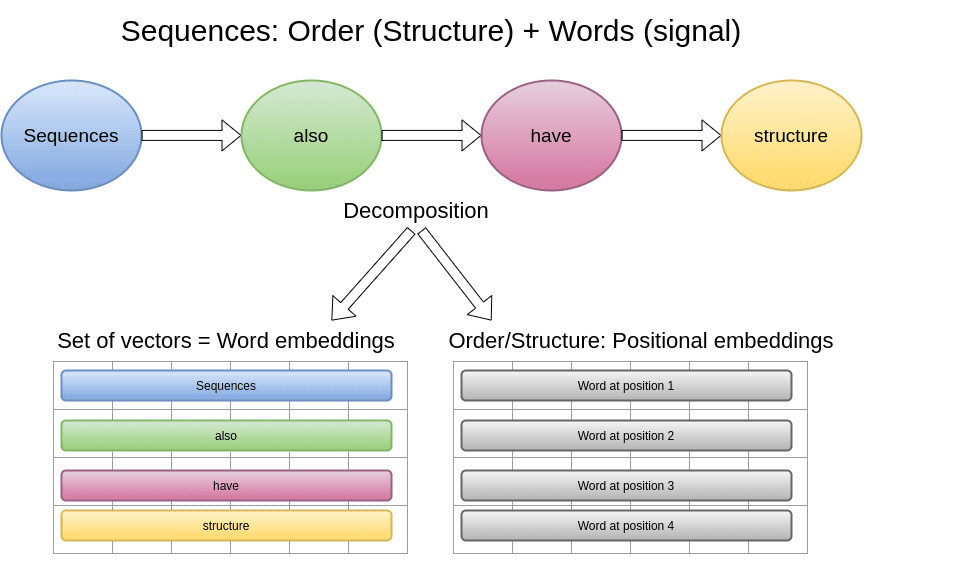

The features will now be a set of word embeddings and the order will be encoded in the positional embeddings.

Graphs are not any different: they are data with decomposed structure and signal information.

Real-world signals that we can model with graphs.

As long as you can define these two representations, you can model anything you want with graphs. Formally, the words or pixels are simply nodes, denoted by N. The connectivity/structure will be defined by a N×N matrix, the so-called Adjacency matrix A. The element i,j of A will tell us if node i is connected to node j.

The signal for each node will be X (N×F) , where F is the number of features. 


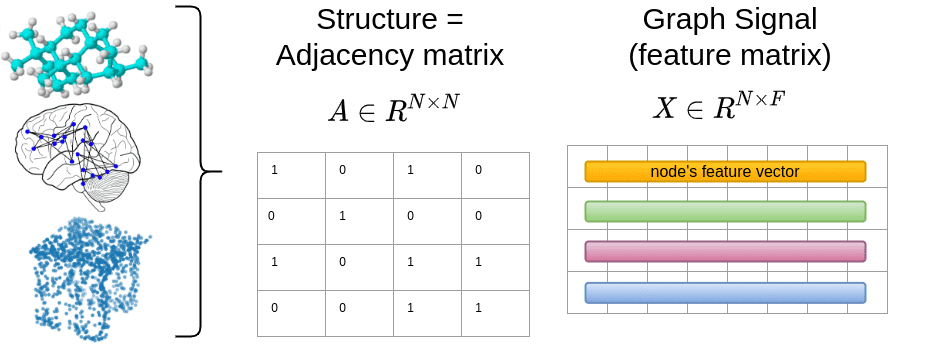

##### **Adjancency matrix**

In [ ]:
import pandas as pd
# read the USERS, POSTS, COMMENTS, COMMUNITIES files in this dir and make dataframes
users_df = pd.read_excel('USERS.xlsx')
communities_df = pd.read_excel('COMMUNITIES.xlsx')
comments_df = pd.read_excel('COMMENTS_21.xlsx')

#create set of communites
communities_set = set(communities_df['Community Name - Hebrew'])

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [ ]:
#create set of users that commented each other without new line

users_set = set()
for index, row in comments_df.iterrows():
    if row['Comment author'] not in users_set:
        users_set.add(row['Comment author'].replace('\n', ''))

In [ ]:
len(users_set)

2718

In [ ]:
# create adjency matrix for users - rows and columns are users. add 1 for each shared community between users

user_adjacency_matrix = pd.DataFrame(0, index=users_set, columns=users_set)
for index, row in comments_df.iterrows():
    if row['Post/Comment'] == 'post':
        user1 = row['Comment author'].replace('\n', '')
    else:
        user2 = row['Comment author'].replace('\n', '')
        user_adjacency_matrix.loc[user1, user2] += 1

In [ ]:
user_adjacency_matrix.shape

(2718, 2718)

In [ ]:
user_adjacency_matrix

,אקסקליבר,יהונתן 23,ג׳ניה,לוצינ,חנהט,שרה1414,השם לא חשוב,לימורה 1,Yakov12,אא242,...,אורפז 2,beny3,רונית4,קרן3331,אבחנה שגוייה,sili88,אפס2,שושנה5772,Gilgolgilgol,אילנה
אקסקליבר,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
יהונתן 23,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ג׳ניה,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
לוצינ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
חנהט,0,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sili88,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
אפס2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
שושנה5772,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gilgolgilgol,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


___________________________________________________________________________________________________________________________________________________

##### **Features matrix**

Doc2vec is an NLP tool for representing documents as a vector and is a generalizing of the word2vec method

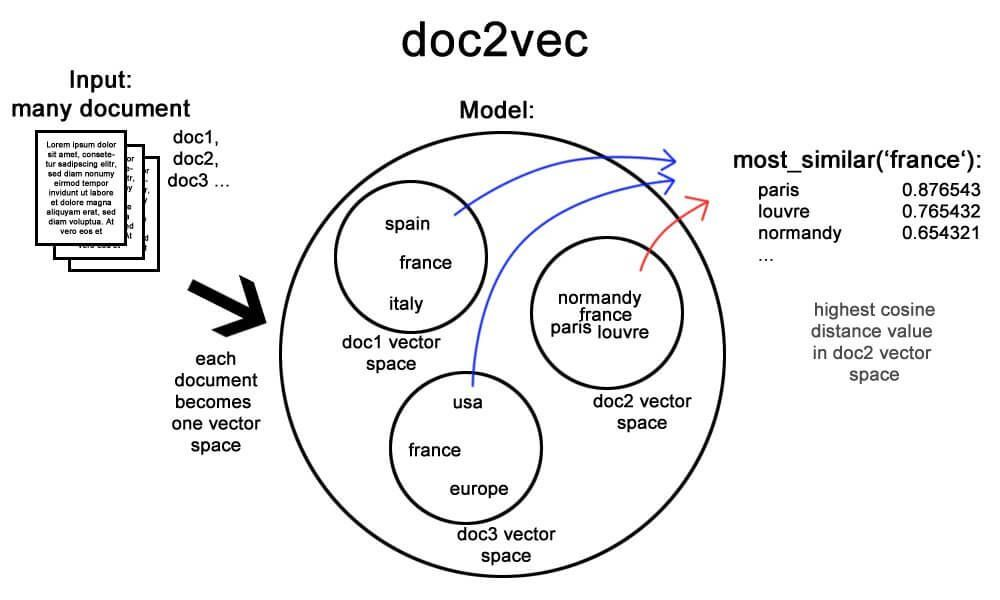

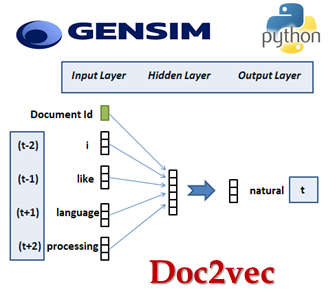

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import re
import pickle
import numpy as np

What are stop words?  The words which are generally filtered out before processing a natural language are called stop words. These are actually the most common words in any language (like articles, prepositions, pronouns, conjunctions, etc) and does not add much information to the text.

In [ ]:
STOP_WORDS = [
    'אני',
    'את',
    'אתה',
    'אנחנו',
    'אתן',
    'אתם',
    'הם',
    'הן',
    'היא',
    'הוא',
    'שלי',
    'שלו',
    'שלך',
    'שלה',
    'שלנו',
    'שלכם',
    'שלכן',
    'שלהם',
    'שלהן',
    'לי',
    'לו',
    'לה',
    'לנו',
    'לכם',
    'לכן',
    'להם',
    'להן',
    'אותה',
    'אותו',
    'זה',
    'זאת',
    'אלה',
    'אלו',
    'תחת',
    'מתחת',
    'מעל',
    'בין',
    'עם',
    'עד',
    'נגר',
    'על',
    'אל',
    'מול',
    'של',
    'אצל',
    'כמו',
    'אחר',
    'אותו',
    'בלי',
    'לפני',
    'אחרי',
    'מאחורי',
    'עלי',
    'עליו',
    'עליה',
    'עליך',
    'עלינו',
    'עליכם',
    'לעיכן',
    'עליהם',
    'עליהן',
    'כל',
    'כולם',
    'כולן',
    'כך',
    'ככה',
    'כזה',
    'זה',
    'זות',
    'אותי',
    'אותה',
    'אותם',
    'אותך',
    'אותו',
    'אותן',
    'אותנו',
    'ואת',
    'את',
    'אתכם',
    'אתכן',
    'איתי',
    'איתו',
    'איתך',
    'איתה',
    'איתם',
    'איתן',
    'איתנו',
    'איתכם',
    'איתכן',
    'יהיה',
    'תהיה',
    'היתי',
    'היתה',
    'היה',
    'להיות',
    'עצמי',
    'עצמו',
    'עצמה',
    'עצמם',
    'עצמן',
    'עצמנו',
    'עצמהם',
    'עצמהן',
    'מי',
    'מה',
    'איפה',
    'היכן',
    'במקום שבו',
    'אם',
    'לאן',
    'למקום שבו',
    'מקום בו',
    'איזה',
    'מהיכן',
    'איך',
    'כיצד',
    'באיזו מידה',
    'מתי',
    'בשעה ש',
    'כאשר',
    'כש',
    'למרות',
    'לפני',
    'אחרי',
    'מאיזו סיבה',
    'הסיבה שבגללה',
    'למה',
    'מדוע',
    'לאיזו תכלית',
    'כי',
    'יש',
    'אין',
    'אך',
    'מנין',
    'מאין',
    'מאיפה',
    'יכל',
    'יכלה',
    'יכלו',
    'יכול',
    'יכולה',
    'יכולים',
    'יכולות',
    'יוכלו',
    'יוכל',
    'מסוגל',
    'לא',
    'רק',
    'אולי',
    'אין',
    'לאו',
    'אי',
    'כלל',
    'נגד',
    'אם',
    'עם',
    'אל',
    'אלה',
    'אלו',
    'אף',
    'על',
    'מעל',
    'מתחת',
    'מצד',
    'בשביל',
    'לבין',
    'באמצע',
    'בתוך',
    'דרך',
    'מבעד',
    'באמצעות',
    'למעלה',
    'למטה',
    'מחוץ',
    'מן',
    'לעבר',
    'מכאן',
    'כאן',
    'הנה',
    'הרי',
    'פה',
    'שם',
    'אך',
    'ברם',
    'שוב',
    'אבל',
    'מבלי',
    'בלי',
    'מלבד',
    'רק',
    'בגלל',
    'מכיוון',
    'עד',
    'אשר',
    'ואילו',
    'למרות',
    'אס',
    'כמו',
    'כפי',
    'אז',
    'אחרי',
    'כן',
    'לכן',
    'לפיכך',
    'מאד',
    'עז',
    'מעט',
    'מעטים',
    'במידה',
    'שוב',
    'יותר',
    'מדי',
    'גם',
    'כן',
    'נו',
    'אחר',
    'אחרת',
    'אחרים',
    'אחרות',
    'אשר',
    'או']


In [ ]:
def pre_process_text(text):
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # remove stop words
    text_ = [word for word in text.split() if word not in STOP_WORDS]

    # remove not hebrew letters
    my_word = re.sub(r'[^אבגדהוזחטיכלמנסעפצקרשתםןץףך]{3,}', ' ', ' '.join(text_))
    my_word2 = re.sub(r'(\s)([אבגדהוזחטיכלמנסעפצקרשתםןץףך])(\s)', ' ', my_word)

    return my_word2

In [ ]:
comments_df = pd.read_excel('COMMENTS_21.xlsx')
texts = []
clean_texts = []
tokenized_texts = []
tagged_texts = [] 

In [ ]:
for index, row in comments_df.iterrows():
    texts.append(row.Comment)  # create text list
    clean_txt = pre_process_text(row.Comment)
    clean_texts.append(clean_txt)  # create pre-processed text list
# add to dataframe column with the clean text
comments_df['Clean Text'] = clean_texts 

In [ ]:
import nltk
nltk.download('punkt') # necessary if there is nltk exception

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# tokenize clean texts and convert into gensim formatted tagged comments_df
for index, text in enumerate(clean_texts):
    tokenized_text = word_tokenize(text)
    tokenized_texts.append(tokenized_text)
    tagged_texts.append(TaggedDocument(words=tokenized_text, tags=[index]))

comments_df['Tagged Text'] = tagged_texts
comments_df['Tokenized Text'] = tokenized_texts

In [ ]:
# create doc2vec model
model = Doc2Vec(vector_size=300,  # size of vector for each document
                    min_count=30,  # Ignore words with total frequency lower than this. (rare words can harm the model)
                    epochs=10,  # Number of iterations (epochs) over the corpus
                    alpha=0.05,  # The initial learning rate.
                    dm=1,  # training algo. 1 for ‘distributed memory’ (PV-DM). else, distributed bag of words (PV-DBOW)
                    workers=8
                    # Use these many worker threads to train the model (=faster training with multicore machines).
                    )

# Build vocabulary from a sequence of documents
model.build_vocab(tagged_texts)

# train model - update the model’s neural weights.
model.train(tagged_texts, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
vectors = []
for index, row in comments_df.iterrows():
  # get the vector for each comment
  vector = model.infer_vector(row['Tokenized Text'])
  
  # add the vector to the dataframe
  vectors.append(vector)

comments_df['Vector'] = vectors

In [ ]:
# for each user in the dataframe, get the average vector of all the comments of that user and save to dictionary
user_vectors = {}
for index, row in comments_df.iterrows():
    user_id = row['Comment author'].replace('\n', '')
    if user_id not in user_vectors:
        user_vectors[user_id] = []
    user_vectors[user_id].append(row['Vector'])

for user_id in user_vectors:
    user_vectors[user_id] = np.mean(user_vectors[user_id], axis=0)

In [ ]:
user_features_df = pd.DataFrame.from_dict(user_vectors, orient='index')
user_features_df.index.name = 'User'

In [ ]:
user_features_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
User,,,,,,,,,,,,,,,,,,,,,
לביא שיפמן,0.012387,0.001694,0.032121,-0.050055,0.013285,-0.064818,0.036994,-0.046931,0.124441,-0.096156,...,-0.034320,0.052031,0.038010,0.021798,-0.034802,-0.102588,-0.020286,0.031289,0.073643,0.040964
ערן ברקוביץ,0.047008,-0.039160,0.044326,-0.023740,0.000921,-0.005619,0.053656,0.012595,0.165524,-0.084425,...,-0.086000,0.086533,0.026246,0.062749,-0.053437,-0.059353,-0.006003,0.047069,0.096892,0.123073
עינת מילר,0.046989,-0.030730,0.035256,-0.054597,0.012858,-0.089288,0.072382,-0.002539,0.100460,-0.130199,...,-0.020848,0.042185,0.025328,0.085655,0.000969,-0.070438,0.005483,0.043052,0.110467,0.047681
מיכל13,0.037001,-0.009532,0.078487,-0.010505,0.052992,-0.038547,0.110096,0.029294,0.095377,-0.125572,...,-0.046912,0.072020,0.005165,0.040174,-0.014358,-0.046111,-0.012391,0.045675,0.066557,0.036493
P,-0.008274,-0.000862,0.004504,-0.022397,-0.006051,-0.011253,0.001746,0.004762,-0.007288,0.008870,...,-0.030384,0.009518,0.058777,-0.009283,-0.002408,-0.025681,-0.045203,0.057314,0.033592,-0.037769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yoav446,0.030406,-0.031248,0.068504,-0.066524,0.046165,-0.071200,0.081743,-0.049074,0.221065,-0.191160,...,0.000088,0.100329,0.000478,0.064792,-0.021570,-0.122214,0.019766,-0.032447,0.109199,-0.075470
Markosl,0.105999,0.171658,-0.349084,0.083164,-0.750025,0.527259,-0.094896,0.001166,0.418764,-0.246630,...,0.262761,0.307991,-0.610942,0.098323,0.474140,0.017941,-0.049613,0.145952,-0.139896,0.000437
נשואה מתמודדת,-0.023154,-0.094128,-0.008390,0.022203,-0.051864,-0.035509,-0.041928,-0.115633,0.190482,0.004001,...,-0.131760,0.043856,-0.083314,0.082574,-0.003498,-0.237627,-0.001039,0.110797,-0.014700,0.140217
